In [ ]:
!pip install pdfplumber
!pip install camelot-py[cv]
!pip install --upgrade pymupdf
!pip install google-generativeai
!pip install faiss-cpu
!pip install transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image
!pip install sentence_transformers
!pip install python-dotenv

^C



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from dotenv import load_dotenv
import re
import os, glob
import pdfplumber
import camelot
import pymupdf
import numpy as np
import pandas as pd
from pathlib import Path
import time
import faiss, json
import collections
import fitz
import io
from PIL import Image
import pytesseract
from langchain_core.documents import Document
from openai import OpenAI
from TableRetrieval.table_ingestion import stage1_extract_and_save
from TableRetrieval.table_ingestion import store_in_faiss, save_metadata_mapping
from TableRetrieval.table_agentic_rag import TableAgenticRAG

load_dotenv()

True

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [ ]:
import os

# Example:
# os.environ['GEMINI_API_KEY'] = 'your-key-here'
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

COMPANY_NAME = "Google"

CHUNK_SIZE = 500  # number of words per chunk 

def generate_test_log_path_name(base_path: str): 
    # create the directory if not exist 
    os.makedirs(base_path, exist_ok=True) 
    existing_files = [f for f in os.listdir(base_path) if f.startswith("test_") and f.endswith(".json")] 
    existing_indices = [int(f.split("_")[1].split(".")[0]) for f in existing_files if f.split("_")[1].split(".")[0].isdigit()] 
    next_index = max(existing_indices) + 1 if existing_indices else 1 

    return f"{base_path}/test_{next_index}.json"


## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


In [ ]:
DATA_DIR = "00-data"

# Annual reports (10-Ks)
annual_files = glob.glob(f"{DATA_DIR}/annuals/*.pdf")

# # Quarterly reports (10-Qs)
quarterly_files = glob.glob(f"{DATA_DIR}/quarterlies/*.pdf")

# Presentations
presentation_files = glob.glob(f"{DATA_DIR}/presentations/*.pdf")

In [ ]:
for folder in ["annuals", "quarterlies", "presentations"]:

    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    print(f"{folder}: {len(files)} files")

annuals: 3 files
quarterlies: 11 files
presentations: 2 files


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

### Embeddings

In [ ]:
def create_embeddings(chunks, model="text-embedding-3-small"):
    """
    Create embeddings for chunks using OpenAI.
    Returns: chunks with 'embedding' field added
    """
    print(f"Creating embeddings with {model}...\n")
    print(f"   Total chunks: {len(chunks)}")
    
    client = OpenAI()

    # Split into batches of 50
    batch_size = 50
    total_batches = (len(chunks) + batch_size - 1) // batch_size

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        batch_num = i // batch_size + 1
        print(f"   Processing batch {batch_num} of {total_batches}...")

        contents = [chunk['content'] for chunk in batch]
        
        # Embed batch
        response = client.embeddings.create(
            model=model,
            input=contents
        )
        
        # Add embeddings to chunks
        for j, chunk in enumerate(batch):
            chunk['embedding'] = response.data[j].embedding

        # Small delay to respect rate limits
        if i + batch_size < len(chunks):
                time.sleep(0.6) # Adjust as needed
    
    print(f"Created {len(chunks)} embeddings\n")
    return chunks

### Table Ingestion

In [ ]:
def stage2_create_embeddings(json_file):
    """
    Load extracted tables from JSON and create embeddings.
    This is where you spend OpenAI tokens.
    """
    load_dotenv()
    
    DATA_DIR = "00-data"
    
    print("="*80)
    print("STAGE 2: CREATING EMBEDDINGS")
    print("="*80)
    print()
    
    # Load the extracted tables
    print(f"Loading: {json_file}")
    with open(json_file, 'r') as f:
        table_chunks = json.load(f)
    
    print(f"Loaded {len(table_chunks)} tables")
    
    print("\nCreating embeddings...")
    embedded_chunks = create_embeddings(table_chunks)
    
    print("\nStoring in FAISS...")
    faiss_index = store_in_faiss(
        embedded_chunks,
        faiss_index_path=f"{DATA_DIR}/base/faiss_table_index"
    )
    
    print("\nSaving metadata...")
    save_metadata_mapping(
        embedded_chunks,
        mapping_path=f"{DATA_DIR}/base/faiss_table_metadata.json"
    )
    
    print(f"\n{'='*80}")
    print("COMPLETE!")
    print("="*80)
    print(f"FAISS index: {DATA_DIR}/base/faiss_table_index")
    print(f"Metadata: {DATA_DIR}/base/faiss_table_metadata.json")
    print()

In [ ]:
# Insert table ingestion code here
stage1_extract_and_save()

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

('00-data/extracted_tables.json', 1036)

In [ ]:
stage2_create_embeddings(f"{DATA_DIR}/extracted_tables.json")

STAGE 2: CREATING EMBEDDINGS

Loading: 00-data/extracted_tables.json
Loaded 1036 tables

Creating embeddings...
Creating embeddings with text-embedding-3-small...

   Total chunks: 1036
   Processing batch 1 of 21...
   Processing batch 2 of 21...
   Processing batch 3 of 21...
   Processing batch 4 of 21...
   Processing batch 5 of 21...
   Processing batch 6 of 21...
   Processing batch 7 of 21...
   Processing batch 8 of 21...
   Processing batch 9 of 21...
   Processing batch 10 of 21...
   Processing batch 11 of 21...
   Processing batch 12 of 21...
   Processing batch 13 of 21...
   Processing batch 14 of 21...
   Processing batch 15 of 21...
   Processing batch 16 of 21...
   Processing batch 17 of 21...
   Processing batch 18 of 21...
   Processing batch 19 of 21...
   Processing batch 20 of 21...
   Processing batch 21 of 21...
Created 1036 embeddings


Storing in FAISS...
Stored 1036 vectors in FAISS index at '00-data/base/faiss_table_index'


Saving metadata...
Saved metadat

### Slides Ingestion

In [ ]:
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)


[ImagePipeline] Found 2 presentation PDFs.
[SlidesExtractor] Loaded 00-data/presentations/2025q1-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q1-alphabet-earnings-slides
[SlidesExtractor] Loaded 00-data/presentations/2025q2-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q2-alphabet-earnings-slides
[ImagePipeline] Total OCR slide documents: 20
[FAISS] Saved index → 00-data/base/faiss_image_index
[FAISS] Saved metadata → 00-data/base/faiss_image_metadata.json


### Text Ingestion

In [ ]:
from TextRetrieval.TextExtractor import extract_text_from_pdf
extract_text_from_pdf(); 


No PDF paths provided, loading from default annual and quarterly files.
Processing 14 PDFs from all folders
PDF paths: ['00-data/annuals/goog-10-k-2024.pdf', '00-data/annuals/goog-10-k-2022.pdf', '00-data/annuals/goog-10-k-2023-final.pdf'] ...

=== Processing: goog-10-k-2024.pdf ===
Page 1 → Text length: 2689
Page 2 → Text length: 3253
Page 3 → Text length: 1439
Page 4 → Text length: 3759
Page 5 → Text length: 4750
Page 6 → Text length: 5245
Page 7 → Text length: 4994
Page 8 → Text length: 4815
Page 9 → Text length: 4077
Page 10 → Text length: 5075
Page 11 → Text length: 5246
Page 12 → Text length: 5953
Page 13 → Text length: 5704
Page 14 → Text length: 5464
Page 15 → Text length: 6170
Page 16 → Text length: 5042
Page 17 → Text length: 6112
Page 18 → Text length: 5799
Page 19 → Text length: 5827
Page 20 → Text length: 5768
Page 21 → Text length: 5552
Page 22 → Text length: 5640
Page 23 → Text length: 5929
Page 24 → Text length: 5289
Page 25 → Text length: 4867
Page 26 → Text length: 52

## TEXT FAISS BUILDER
### CREATE THE CHUNKS 
### BUILD THE INDICES BASE OFF THE CHUNKS

In [ ]:
from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 

Created 1223 chunks from the documents.
Building index for section: cover_page with 46 chunks.
Embeddings shape for section cover_page: (46, 1536)
Building index for section: equity with 192 chunks.
Embeddings shape for section equity: (192, 1536)
Building index for section: risk_factors with 117 chunks.
Embeddings shape for section risk_factors: (117, 1536)
Building index for section: mdna with 86 chunks.
Embeddings shape for section mdna: (86, 1536)
Building index for section: summary_financial_data with 194 chunks.
Embeddings shape for section summary_financial_data: (194, 1536)
Building index for section: legal_proceedings with 122 chunks.
Embeddings shape for section legal_proceedings: (122, 1536)
Building index for section: segment_info with 32 chunks.
Embeddings shape for section segment_info: (32, 1536)
Building index for section: financial_statements with 187 chunks.
Embeddings shape for section financial_statements: (187, 1536)
Building index for section: income_statement wit

### Ingestion t_ingest Log

In [ ]:
# Table
from TableRetrieval.table_ingestion import stage1_extract_and_save
table_ingest_start = time.time()
stage1_extract_and_save()
stage2_create_embeddings(f"00-data/extracted_tables.json")
table_ingest_end = time.time() - table_ingest_start

# Slides
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

slides_ingest_start = time.time()
IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)
slides_ingest_end = time.time() - slides_ingest_start

# Text
from TextRetrieval.TextExtractor import extract_text_from_pdf
text_ingest_end = time.time()
extract_text_from_pdf(); 

from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 
text_ingest_end = time.time() - text_ingest_end

print("Ingestion Timing Results")
print(f"Table Ingestion Time: {table_ingest_end} seconds")
print(f"Text Ingestion Time: {text_ingest_end} seconds")
print(f"Slides Ingestion Time: {slides_ingest_end} seconds")

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

In [ ]:
# TODO: Implement baseline retrieval + generation


## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

In [ ]:
# TODO: Implement benchmark runner


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [45]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs


import json
import glob
import pandas as pd

def json_to_flat_row(j):
    t_retrieval = j.get("retrieval_time") or j["callback_summary"].get("retrieval_time", 0)
    t_rerank = j.get("rerank_time", 0)
    t_reason = j["callback_summary"].get("reasoning_time", 0)
    t_generate = j["callback_summary"].get("generation_time", 0)

    return {
        "query": j.get("query"),
        "t_retrieval": t_retrieval,
        "t_rerank": t_rerank,
        "t_reason": t_reason,
        "t_generate": t_generate,
        # recomputed total as sum of components
        "t_total": t_retrieval + t_rerank + t_reason + t_generate,
        "prompt_tokens": j["callback_summary"].get("prompt_tokens"),
        "completion_tokens": j["callback_summary"].get("completion_tokens"),
        "total_tokens": j["callback_summary"].get("total_tokens"),
        "cache_hit": j.get("cache_hit"),
        "tools": ", ".join(j["callback_summary"].get("tools_used", [])),
    }
def load_folder_as_df(path, run_type):
    rows = []
    for file in glob.glob(path):
        with open(file, "r") as f:
            j = json.load(f)
            row = json_to_flat_row(j)
            row["run_type"] = run_type  # Add the new column
            rows.append(row)
    df = pd.DataFrame(rows)
    
    # Calculate aggregated row
    agg_row = {
        "query" : df["query"].iloc[0],
        "run_type": run_type,
        "t_retrieval": df["t_retrieval"].mean(),
        "t_rerank": df["t_rerank"].mean(),
        "t_reason": df["t_reason"].mean(),
        "t_generate": df["t_generate"].mean(),
        "t_total": df["t_total"].mean(),
        "prompt_tokens": df["prompt_tokens"].mean(),
        "completion_tokens": df["completion_tokens"].mean(),
        "total_tokens": df["total_tokens"].mean(),
        "cache_hit": df["cache_hit"].mode()[0] if not df["cache_hit"].mode().empty else None,
        "tools": ", ".join(sorted(set(tool.strip() for tools in df["tools"] for tool in tools.split(",") if tool.strip())))
    }
    
    return pd.DataFrame([agg_row])
df_q1_baseline = load_folder_as_df("00-data/logs/instru_log_testings/baseline/Q1 Gross Margin/*.json", "BASELINE")
df_q1_optimized = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q1/*.json", "OPTIMIZED")
df_q1_cached = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q1/use_cache/*.json", "CACHED")

df_q2_baseline = load_folder_as_df("00-data/logs/instru_log_testings/baseline/Q2 Operating Expense/*.json", "BASELINE")
df_q2_optimized = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q2/*.json", "OPTIMIZED")
df_q2_cached = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q2/use_cache/*.json", "CACHED")

df_q3_baseline = load_folder_as_df("00-data/logs/instru_log_testings/baseline/Q3 OE Ratio/*.json", "BASELINE")
df_q3_optimized = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q3/*.json", "OPTIMIZED")
df_q3_cached = load_folder_as_df("00-data/logs/instru_log_testings/Optimised Q3/use_cache/*.json", "CACHED")

df_q1_combined = pd.concat([df_q1_baseline, df_q1_optimized, df_q1_cached], ignore_index=True)
df_q2_combined = pd.concat([df_q2_baseline, df_q2_optimized, df_q2_cached], ignore_index=True)
df_q3_combined = pd.concat([df_q3_baseline, df_q3_optimized, df_q3_cached], ignore_index=True)

display(df_q1_combined)
display(df_q2_combined)
display(df_q3_combined)


,query,run_type,t_retrieval,t_rerank,t_reason,t_generate,t_total,prompt_tokens,completion_tokens,total_tokens,cache_hit,tools
0,Report the Gross Margin over the last 5 quarte...,BASELINE,2.498300,0.000000,184.05456,3.51760,190.070460,282792.4,11905.5,294697.9,None,"calculator, retriever"
1,Report the Gross Margin over the last 5 quarte...,OPTIMIZED,25.495740,6.982096,1.69036,6.29179,40.459986,7281.1,329.2,7610.3,False,retrieve_table
2,Report the Gross Margin over the last 5 quarte...,CACHED,1.643201,0.272622,0.13874,0.49441,2.548973,726.9,42.7,769.6,True,retrieve_table


,query,run_type,t_retrieval,t_rerank,t_reason,t_generate,t_total,prompt_tokens,completion_tokens,total_tokens,cache_hit,tools
0,Show Operating Expenses for the last 3 fiscal ...,BASELINE,2.315210,0.000000,125.18008,5.87435,133.369640,102799.5,9345.2,112144.7,None,"calculator, retriever"
1,Show Operating Expenses for the last 3 fiscal ...,OPTIMIZED,18.561032,12.696369,3.51776,4.09559,38.870751,8949.8,472.4,9422.2,False,retrieve_table
2,Show Operating Expenses for the last 3 fiscal ...,CACHED,1.785562,1.185243,0.44804,0.35620,3.775045,1462.3,51.8,1514.1,True,retrieve_table


,query,run_type,t_retrieval,t_rerank,t_reason,t_generate,t_total,prompt_tokens,completion_tokens,total_tokens,cache_hit,tools
0,Calculate the Operating Efficiency Ratio (Opex...,BASELINE,4.593450,0.000000,151.15733,5.12091,160.871690,196259.7,12136.3,208396.0,None,"calculator, retriever"
1,Calculate the Operating Efficiency Ratio (Opex...,OPTIMIZED,15.983224,10.438357,2.46234,6.67029,35.554211,12315.6,556.2,12871.8,False,retrieve_table
2,Calculate the Operating Efficiency Ratio (Opex...,CACHED,1.640657,0.412932,0.49142,0.84285,3.387859,2328.5,76.5,2405.0,True,retrieve_table


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [ ]:
# TODO: Implement optimizations


### Table Agentic Optimization

In [ ]:
FAISS_INDEX = f"{DATA_DIR}/base/faiss_table_index"
METADATA_JSON = f"{DATA_DIR}/base/faiss_table_metadata.json"

# Create the agent
table_agent = TableAgenticRAG(
    faiss_index_path=FAISS_INDEX,
    metadata_json_path=METADATA_JSON
)

query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."


print("\nRunning agent query...\n")
result = table_agent.query(query, verbose=True)


print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query...


QUERY: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for accurate year-on-year comparison.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for accurate year-on-year comparison.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 9

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 1700 characters


====================== ANSWER ======================
To

In [ ]:
query2 = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
print("\nRunning agent query 2...\n")
result = table_agent.query(query2, verbose=True)

print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query 2...


QUERY: What is the operating expense for the last 3 fiscal years, year-on-year comparison.

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for the operating expenses of 2023.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for the operating expenses of 2024.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for the operating expenses of 2025.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 9

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 1716 characters


====================== ANSWER ======================


### TEXT Agentic Optimization

In [ ]:
# from TextRetrieval.Agent import text_agent_executor

# query = "" \
# "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
# text_agent_executor(query)

### Image Query

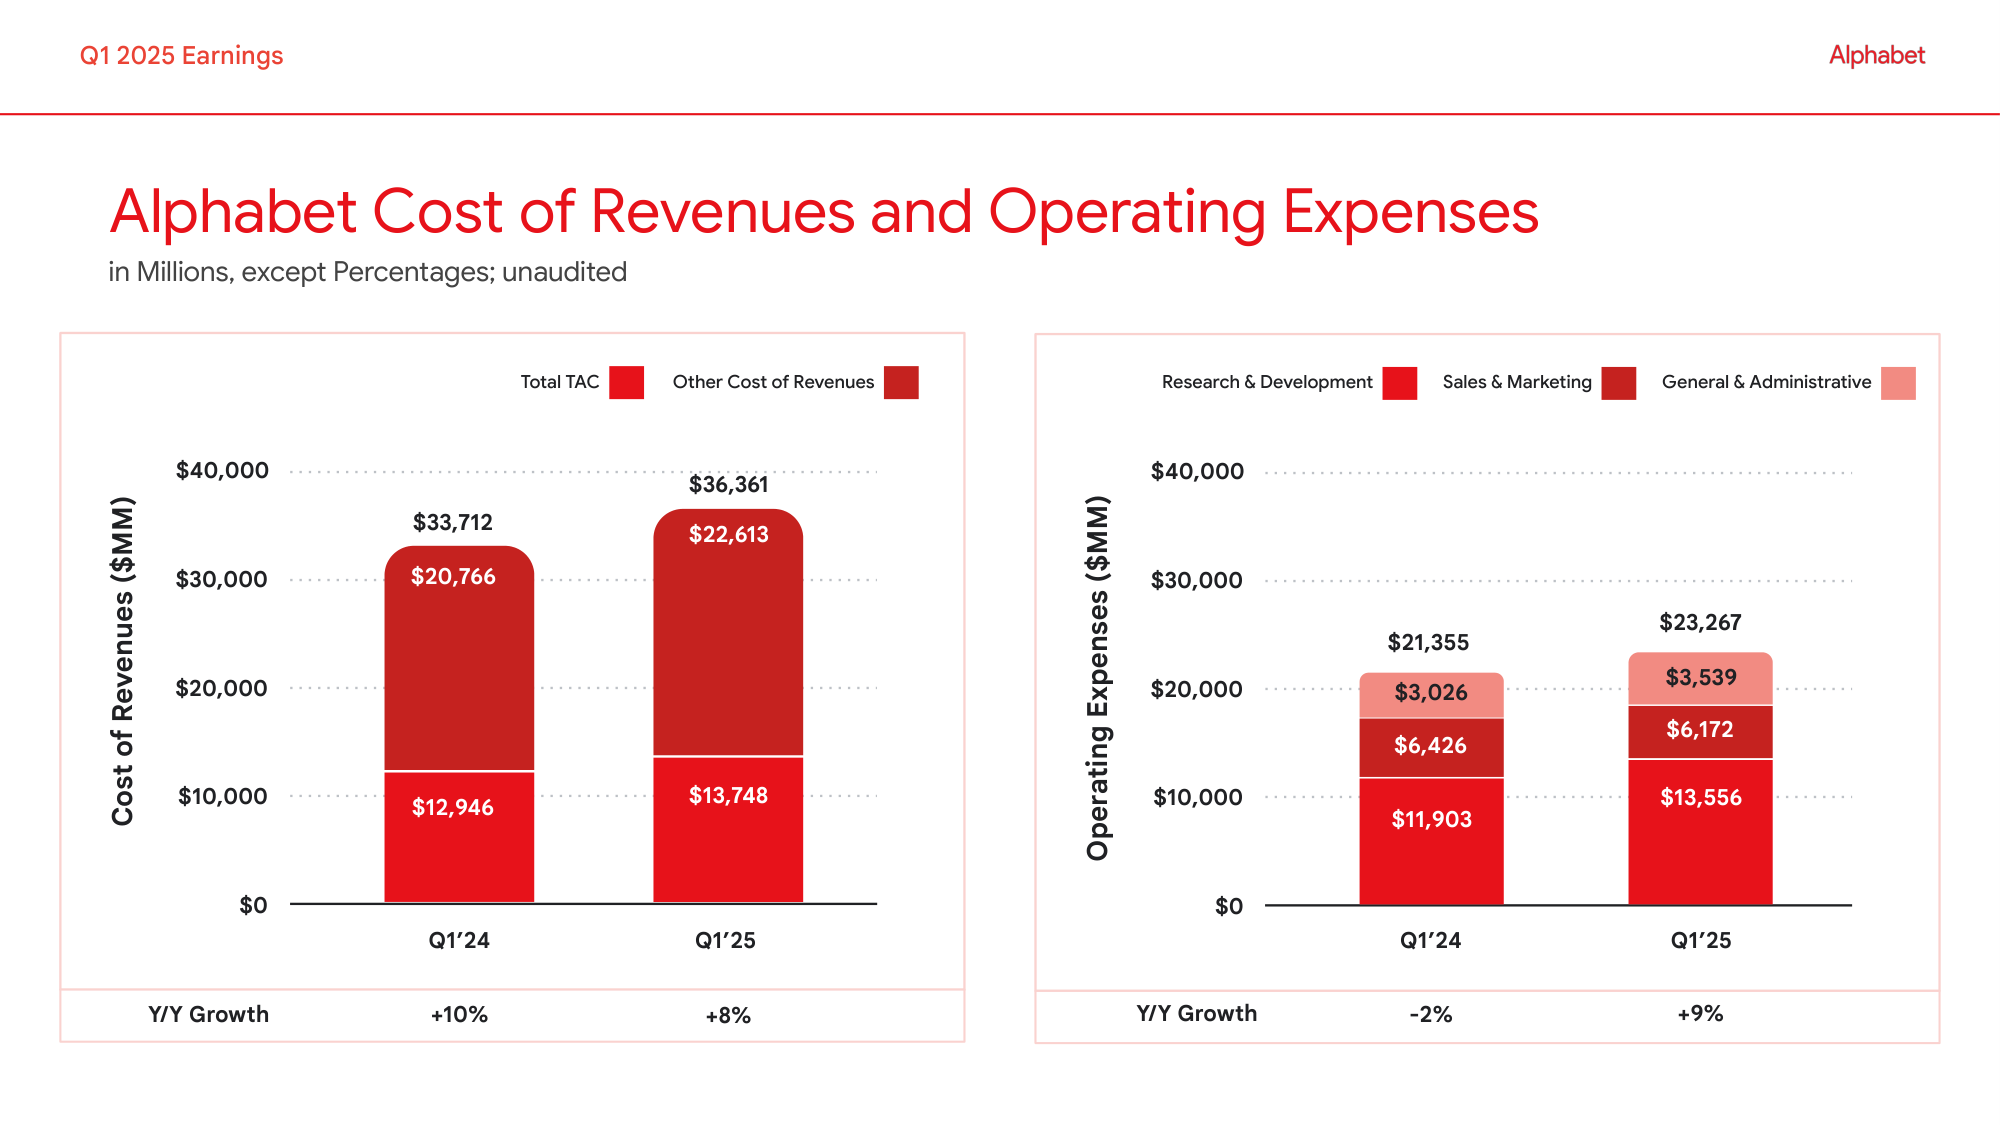

In [ ]:
from PIL import Image
IMAGE_INDEX = "00-data/base/faiss_image_index"
IMAGE_META  = "00-data/base/faiss_image_metadata.json"

image_retriever = ImageRetriever(IMAGE_INDEX, IMAGE_META)
query = "What are the operating expenses?"
results = image_retriever.search(query, k=5)
results
path = results[0]["metadata"]["image_path"]
Image.open(path)


## Unified Agent Query Response

In [ ]:
# from UnifiedCFOAgent import create_cfo_agent

# agent = create_cfo_agent()

# query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."

# # response = agent.invoke({"input": query})

# response = agent.invoke({"input": query}, return_intermediate_steps=True)

# print(response)


In [ ]:
import os

print("Folders in sections:")
print(os.listdir("00-data/sections"))

print("\nFiles inside acquisitions folder:")
print(os.listdir("00-data/sections/acquisitions"))


Folders in sections:
['market_risk_disclosures', 'cover_page', 'controls_procedures', 'income_statement', 'signatures', 'financial_statements', 'legal_proceedings', 'mdna', 'summary_financial_data', 'exhibits', 'risk_factors', 'segment_info', 'balance_sheet', 'equity', 'cash_flow']

Files inside acquisitions folder:


FileNotFoundError: [Errno 2] No such file or directory: '00-data/sections/acquisitions'

In [ ]:
from UnifiedCFOAgent import query_cfo_agent
question = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement', 'financial_statements']
[TextSectionRetriever] Using k=40 for query: 'Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.'
[INFO] Searching 2 sections for: 'Show operating expenses (also referred to as "SG&A", "selling, general and administrative expenses", "total expenses", or "operating costs") for the last 3 fiscal years, with year-over-year comparison. Include data from both annual and quarterly periods (e.g., "fiscal year", "year ended", "quarter ended") as reported in the "Consolidated Statements of Income", "Statements of Operations", or similar financial statements. Retrieve all relevant line items and breakdowns for comprehensive comparison.'
[INFO] FAISS indices already initialize

/Users/vanessatan/Documents/GitHub/PTO/UnifiedCFOAgent.py:226: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


Question: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.
Thought: To provide the operating expenses for the last 3 fiscal years and their year-on-year comparison, I need to retrieve the financial tables related to operating expenses from the company's annual or quarterly filings.
Action: retrieve_table
Action Input: Operating Expenses last 3 fiscal years[RETRIEVE_TABLE] Completed table retrieval.


Observation: {"query": "Operating Expenses last 3 fiscal years", "answer": "To determine the operating expenses for the last three fiscal years, we will focus on the General and Administrative (G&A) expenses as provided in the retrieved data. The G&A expenses are a component of operating expenses. Below is a summary of the G&A expenses for the fiscal years 2021, 2022, and 2023.\n\n### General and Administrative Expenses (in millions)\n\n| Year | G&A Expenses | Source                      |\n|------|--------------|-----------------------------|\n| 2021 | $13,510

In [ ]:
question = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

In [ ]:
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
question = "What are the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
question = "Where can i get a graphic representation of the operating expenses?"
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response)

In [ ]:
from UnifiedCFOAgent import query_cfo_agent
question = "Summarize management's discussion about operating cost trends. Display any relevant images, text and tables."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=True
)

print(response["answer"])
print(response["metadata"])

In [ ]:
from UnifiedCFOAgent import query_cfo_agent
question = "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
response = query_cfo_agent(
    question,
    cache_threshold=0.85,
    use_cache=False
)

print(response["answer"])
print(response["metadata"])

[INFO] FAISS indices already initialized, reusing existing indices.
[TextSectionRetriever] Loaded 15 section indices from 00-data/sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement']
[TextSectionRetriever] Using k=40 for query: 'Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.'
[INFO] Searching 1 sections for: 'Retrieve data on operating expenses (also referred to as "Opex", "SG&A", "selling, general and administrative expenses", or "total expenses") and operating income (also called "income from operations" or "operating profit") from the Consolidated Statements of Income or Statements of Operations in SEC filings. Include figures for the last 3 fiscal years and, if available, for each quarter ("quarter ended", "annual", "fiscal year ended"). Show calculations for the Operating Efficiency Ratio (operating expenses divi

### RAG TRIAD + ACCURACY TESTING (van)

In [ ]:
import sys
sys.path.append("./RAG")

# to reset the imported modules
import importlib
import rag_helpers
import run_rag

importlib.reload(rag_helpers)
importlib.reload(run_rag)

from run_rag import compute_manual_ctx, run_full_rag_benchmark, run_full_rag_benchmark_text_and_table_only

# ======================================= # Benchmark Queries # ======================================= 
benchmark_queries = [
    {"id": 1, "name": "Gross Margin Trend", "query": "What is the gross margin trend for the last 3 years?"},
    {"id": 2, "name": "Operating Expenses YoY", "query": "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."},
    {"id": 3, "name": "Operating Efficiency Ratio", "query": "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years."}
]



### Rag with text + table context relevance

In [ ]:
results_df, answers_df = run_full_rag_benchmark_text_and_table_only(benchmark_queries)

display(results_df)
display(answers_df)

### Rag with text only context relevance

In [ ]:
# must run before running the rag triad
manual_ctx = compute_manual_ctx(benchmark_queries)

In [ ]:
df_results, df_answers = run_full_rag_benchmark(benchmark_queries, manual_ctx)

display(df_results)
display(df_answers)


NameError: name 'manual_ctx' is not defined

John Testing 

Latency + Instrumentation Logs (plan to run more times to plot p50,p95, but need check if existing correct)

In [ ]:
import time
import numpy as np
import pandas as pd
from UnifiedCFOAgent import query_cfo_agent

num_runs = 10
test_queries = [
    # "Report the Gross Margin over the last 5 quarters, with values.",
    # "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
    "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
]
detailed = []  # store every query's latency and summary
run_summaries = []  # store per-run totals

for run in range(1, num_runs + 1):
    print(f"=== Run {run} ===")
    start_run = time.time()

    for q in test_queries:
        q_start = time.time()
        resp = query_cfo_agent(q, cache_threshold=0.85, use_cache=True)

        q_end = time.time()

        latency_s = q_end - q_start

        # Store detailed info
        detailed.append({
            "run": run,
            "query": q,
            "latency_s": latency_s,
        })

    # End of run metrics
    run_total_s = time.time() - start_run
    throughput_qps = len(test_queries) / run_total_s

    run_summaries.append({
        "run": run,
        "run_total_s": run_total_s,
        "throughput_qps": throughput_qps,
        "avg_latency_s": latency_s  # only one query, so avg = latency
    })

df_runs = pd.DataFrame(run_summaries)
df_details = pd.DataFrame(detailed)

display(df_runs)

# --- FINAL LATENCY METRICS (ALL RUNS) ---
all_latencies = df_details["latency_s"].values

final_avg_latency = all_latencies.mean()
final_p50_latency = np.percentile(all_latencies, 50)
final_p95_latency = np.percentile(all_latencies, 95)

print("\n=== FINAL LATENCY METRICS (ALL RUNS) ===")
print(f"Average Latency (s): {final_avg_latency}")
print(f"P50 Latency (s):    {final_p50_latency}")
print(f"P95 Latency (s):    {final_p95_latency}")

# --- FINAL THROUGHPUT METRIC (ALL RUNS) ---
total_queries = len(df_details)  # total queries across all runs
total_time = df_runs["run_total_s"].sum()

final_throughput = total_queries / total_time

print("\n=== FINAL THROUGHPUT (ALL RUNS) ===")
print(f"Total Queries:       {total_queries}")
print(f"Total Time (s): {total_time}")
print(f"Overall Throughput:  {final_throughput} queries/sec")


=== Run 1 ===
Cache MISS

[INFO] Initializing FAISS indices from disk...
[TextSectionRetriever] Loaded 15 section indices from 00-data\sections

[PARALLEL] Starting parallel retrieval...
[RETRIEVE_IMAGE] Retrieved 5 images.

[TextSectionRetriever] Searching sections: ['income_statement']
[TextSectionRetriever] Using k=40 for query: 'Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.'
[INFO] Searching 1 sections for: 'Retrieve data on operating expenses (also referred to as "Opex", "SG&A", "selling, general and administrative expenses", or "total expenses") and operating income (also called "income from operations", "operating profit", or "operating earnings") from the Consolidated Statements of Income or Statements of Operations in SEC filings. Include figures for the last 3 fiscal years and, if available, for the quarters ended. Use both annual ("fiscal year", "year ended") and quarterly ("quarter ended") periods to cal

d:\PTO\UnifiedCFOAgent.py:257: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Question: Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.
Thought: To calculate the Operating Efficiency Ratio for the last 3 fiscal years, I need the Operating Expenses (Opex) and Operating Income for each of those years. I will first retrieve the financial tables that include Opex and Operating Income for the last 3 fiscal years.
Action: retrieve_table
Action Input: Operating Expenses and Operating Income for the last 3 fiscal years[RETRIEVE_TABLE] Completed table retrieval.


Observation: {"query": "Operating Expenses and Operating Income for the last 3 fiscal years", "answer": "To determine the Operating Expenses and Operating Income for the last three fiscal years, we will extract and calculate the necessary data from the provided information.\n\n### Operating Income for the Last 3 Fiscal Years\n\nThe operating income for each year is directly provided in the retrieved data

,run,run_total_s,throughput_qps,avg_latency_s
0,1,57.201755,0.017482,57.201755
1,2,0.372504,2.684537,0.372504
2,3,0.354389,2.821758,0.354389
3,4,0.365988,2.732333,0.365988
4,5,0.348595,2.868657,0.348595
5,6,0.423879,2.359162,0.423879
6,7,0.374255,2.671975,0.374255
7,8,0.373704,2.675917,0.373704
8,9,0.384489,2.600854,0.384489
9,10,0.325003,3.076891,0.325003


,run,query,latency_s
0,1,Calculate the Operating Efficiency Ratio (Opex...,57.201755
1,2,Calculate the Operating Efficiency Ratio (Opex...,0.372504
2,3,Calculate the Operating Efficiency Ratio (Opex...,0.354389
3,4,Calculate the Operating Efficiency Ratio (Opex...,0.365988
4,5,Calculate the Operating Efficiency Ratio (Opex...,0.348595
5,6,Calculate the Operating Efficiency Ratio (Opex...,0.423879
6,7,Calculate the Operating Efficiency Ratio (Opex...,0.374255
7,8,Calculate the Operating Efficiency Ratio (Opex...,0.373704
8,9,Calculate the Operating Efficiency Ratio (Opex...,0.384489
9,10,Calculate the Operating Efficiency Ratio (Opex...,0.325003



=== FINAL LATENCY METRICS (ALL RUNS) ===
Average Latency (s): 6.052456045150757
P50 Latency (s):    0.3731037378311157
P95 Latency (s):    31.651710736751497

=== FINAL THROUGHPUT (ALL RUNS) ===
Total Queries:       10
Total Wall Time (s): 60.52456045150757
Overall Throughput:  0.16522218295186175 queries/sec


## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

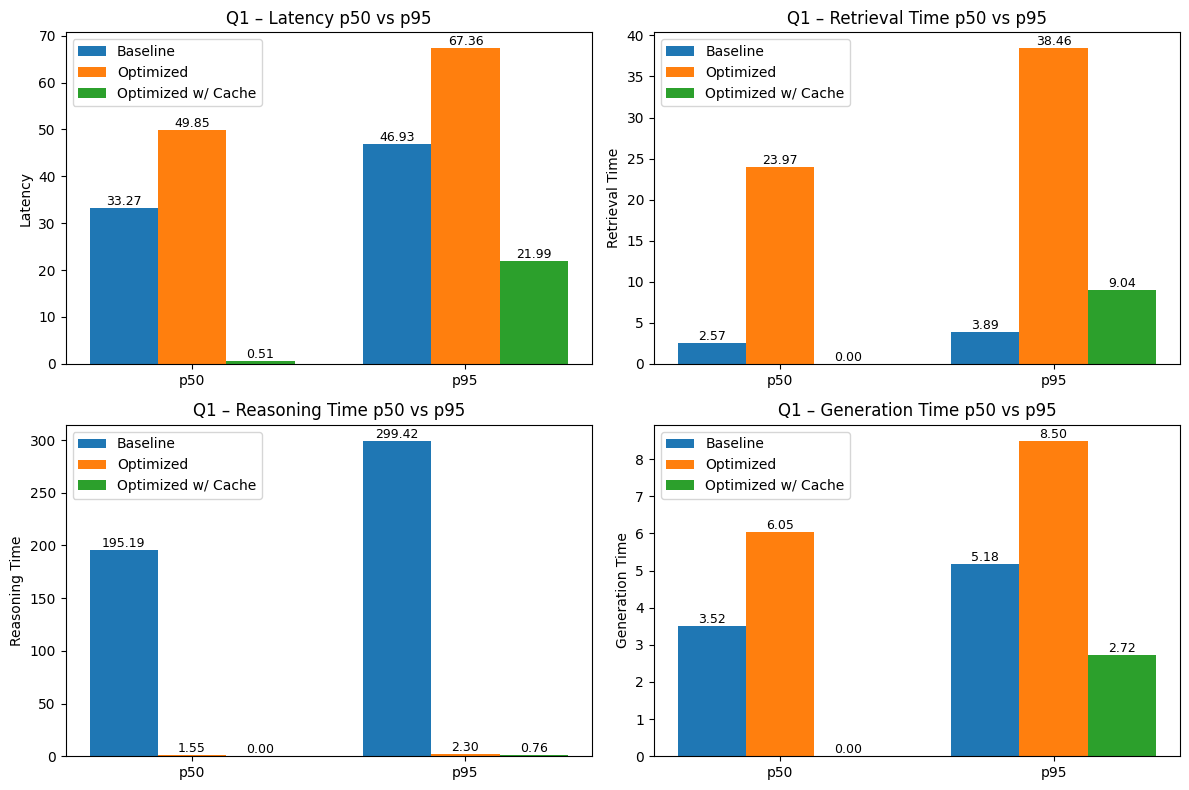

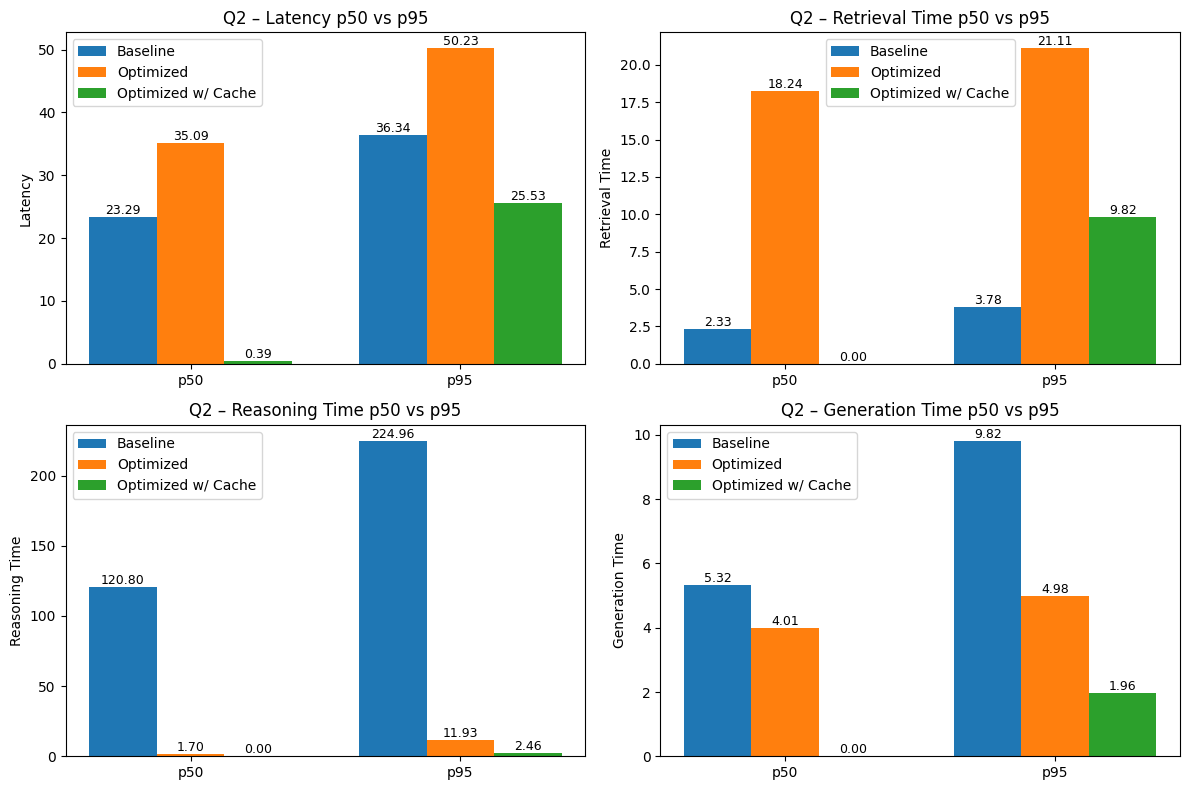

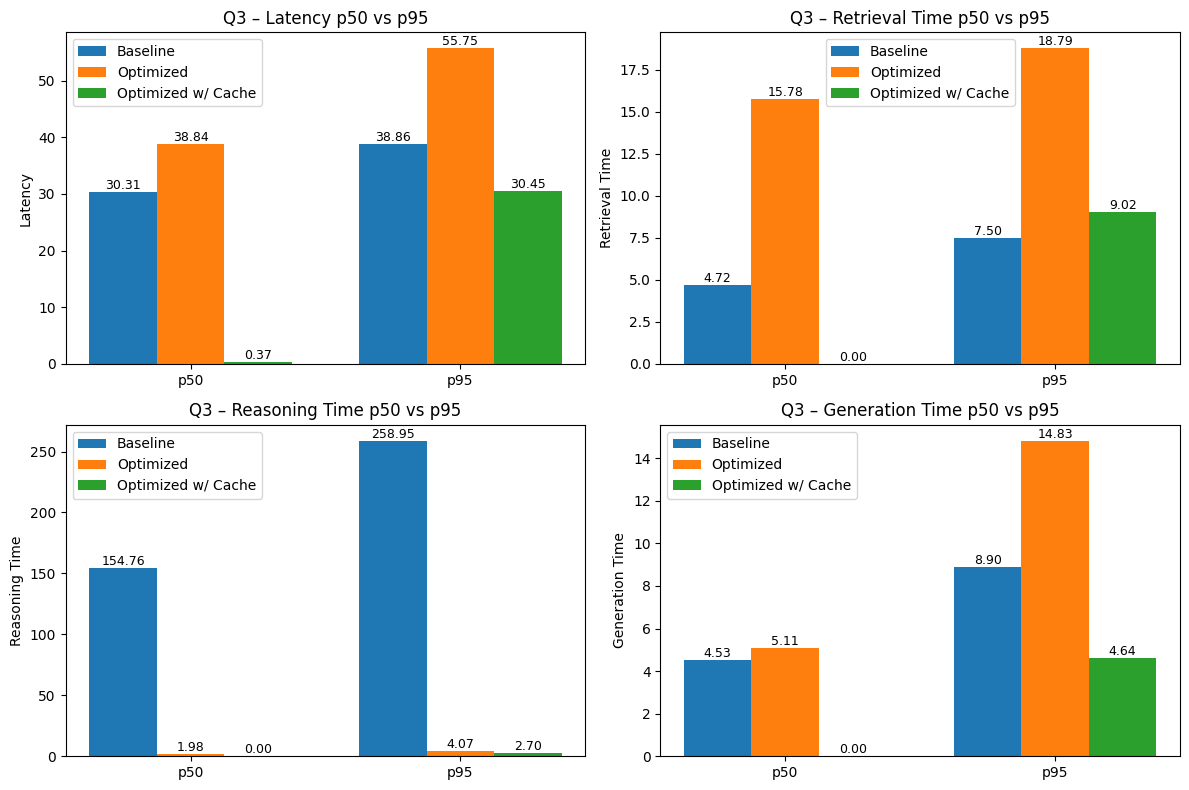

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import glob

def load_runs(path):
    runs = []
    for file in glob.glob(path):
        with open(file, "r") as f:
            runs.append(json.load(f))
    return pd.DataFrame(runs)

def expand_callback_columns(df):
    if "callback_summary" in df.columns:
        df["reasoning_time"] = df["callback_summary"].apply(lambda x: x.get("reasoning_time", np.nan))
        df["generation_time"] = df["callback_summary"].apply(lambda x: x.get("generation_time", np.nan))
    if "retrieval_time" not in df.columns and "callback_summary" in df.columns:
        df["retrieval_time"] = df["callback_summary"].apply(lambda x: x.get("retrieval_time", np.nan))
    if "latency_s" in df.columns:
        df.rename(columns={"latency_s": "latency"}, inplace=True)
    return df

# Load data for each query
queries = ["Q1", "Q2", "Q3"]
baseline_paths = [
    "00-data/logs/instru_log_testings/baseline/Q1 Gross Margin/*.json",
    "00-data/logs/instru_log_testings/baseline/Q2 Operating Expense/*.json",
    "00-data/logs/instru_log_testings/baseline/Q3 OE Ratio/*.json"
]
optimized_paths = [
    "00-data/logs/instru_log_testings/Optimised Q1/*.json",
    "00-data/logs/instru_log_testings/Optimised Q2/*.json",
    "00-data/logs/instru_log_testings/Optimised Q3/*.json"
]
cache_paths = [
    "00-data/logs/instru_log_testings/Optimised Q1/use_cache/*.json",
    "00-data/logs/instru_log_testings/Optimised Q2/use_cache/*.json",
    "00-data/logs/instru_log_testings/Optimised Q3/use_cache/*.json"
]

dfs_baseline = [expand_callback_columns(load_runs(p)) for p in baseline_paths]
dfs_optimized = [expand_callback_columns(load_runs(p)) for p in optimized_paths]
dfs_cache = [expand_callback_columns(load_runs(p)) for p in cache_paths]

metrics = ["latency", "retrieval_time", "reasoning_time", "generation_time"]

for i, query in enumerate(queries):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    df_b = dfs_baseline[i]
    df_o = dfs_optimized[i]
    df_c = dfs_cache[i]

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Compute p50 and p95
        baseline_vals = [df_b[metric].quantile(0.5), df_b[metric].quantile(0.95)]
        optimized_vals = [df_o[metric].quantile(0.5), df_o[metric].quantile(0.95)]
        cache_vals = [df_c[metric].quantile(0.5), df_c[metric].quantile(0.95)]

        labels = ["p50", "p95"]
        x = np.arange(len(labels))
        width = 0.25

        bars_b = ax.bar(x - width, baseline_vals, width, label="Baseline")
        bars_o = ax.bar(x, optimized_vals, width, label="Optimized")
        bars_c = ax.bar(x + width, cache_vals, width, label="Optimized w/ Cache")

        # Add numbers on top of bars
        for bar_group in [bars_b, bars_o, bars_c]:
            for bar in bar_group:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
                        ha='center', va='bottom', fontsize=9)

        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.set_title(f"{query} – {metric.replace('_', ' ').title()} p50 vs p95")
        ax.legend()

    plt.tight_layout()
    plt.show()
